# Project 4: West Nile Virus Prediction

## Modeling
   ---
  *By Ethan Koh,
      Grace Chia,
      Jocelyn Pok,
      Randy Neo,                    5 June 2020*

# Background

West Nile Virus <sup>1</sup> (WNV) is usually spread to humans through infected mosquitos. Around 20% of individuals who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.<br/>

In 2002, Chicago recorded it's first human incident of West Nile virus. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had built a comprehensive surveillance and control program that is still in effect today.<br/>

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray ariel pesticides to reduce adult mosquito populations. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the week ends. The test results include the number of mosquitos, the mosquitos species, and whether West Nile virus is present in the cohort.

This project is from: https://www.kaggle.com/c/predict-west-nile-virus/overview.


# Problem Statement
Due to a recent outbreak of the West Nile Virus in the city of Chicago, the Data Science team at the Disease and Treatment Agency has been tasked by the
Centers for Disease Control (CDC) to develop a strategy to deploy the effective use of pesticides. Targeting spraying efforts to areas of high risk will help to mitigate future outbreaks.<br/>

Leveraging on weather, location, mosquito population and spraying data, we will build a binary classification model that predicts the presence of the West Nile Virus in the city of Chicago. The model that achieves the highest ROC AUC score on the validation set, will be selected as our production model. The model is also expected to outperform the baseline ROC AUC score of 0.5. A cost-benefit analysis will also be done to determine if the benefits of spraying outweighs its costs.

# Executive Summary

Out of all the classification models built, XGBoost was selected as it achieved the highest ROC AUC score on the validation set. The model attained an ROC AUC of 0.83 on the validation set, outperforming the baseline score of 0.5. As observed from the model's feature importance, it turns out that seasonality plays a very key role in mosquito breeding and the spread of WNV, with 'month' being the most important predictor. Besides other sesonality features like 'week' and 'day', 14-day rolling weather conditions like wetbulb, dewpoint and temperature are also key in predicting the presence of WNV in the City of Chicago. The model received a 0.76 ROC AUC score on Kaggle.<br/>

Based on the cost benefit analysis, spraying at areas with more than 12 WNV cases overweighs the cost of the spray, suggesting that spraying at those areas is the most cost effective solution. In addition, reduction in cost of 1 WNV case overweights the spraying of of 10km² area.<br/>

As the model performs relatively well on unseen data, the Disease and Treatment Agency will now be able deploy pesticide-spraying efforts to areas of high risk. An efficient allocation of resources will help help to clamp down on the WNV outbreak, reducing residents' exposure to the virus. 




# Contents

- [Import Libraries](#Import-Libraries)
- [Load Data](#Load-Data)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)
- [Cost Benefit Analysis](#Cost-Benefit-Analysis)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import plotly.express as px # conda install -c plotly plotly
import geopy.distance # Install geopy using 'conda install -c conda-forge geopy'
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

%matplotlib inline

# Load Data

In [2]:
# Read in clean training set
df = pd.read_csv('../data/clean_train_weather.csv')

In [3]:
# Check shape of training set
df.shape

(10506, 30)

In [4]:
# View first 5 rows of df
df.head()

,latitude,longitude,wnvpresent,day,week,month,year,heavy_rain_last_14_days_count,light_rain_last_14_days_count,tmax_rolling_14,tmin_rolling_14,tavg_rolling_14,depart_rolling_14,dewpoint_rolling_14,wetbulb_rolling_14,heat_rolling_14,cool_rolling_14,preciptotal_rolling_14,stnpressure_rolling_14,sealevel_rolling_14,resultspeed_rolling_14,resultdir_rolling_14,avgspeed_rolling_14,day_length_rolling_14,spray_cluster,dist_from_ohare,dist_from_doty,species_culex_pipiens,species_culex_pipiens/restuans,species_culex_restuans
0,41.954690,-87.800991,0,149,22,5,2007,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,7.754490,35.430907,0,1,0
1,41.954690,-87.800991,0,149,22,5,2007,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,7.754490,35.430907,0,0,1
2,41.994991,-87.769279,0,149,22,5,2007,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,10.304920,38.390522,0,0,1
3,41.974089,-87.824812,0,149,22,5,2007,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,5.454421,38.270018,0,1,0
4,41.974089,-87.824812,0,149,22,5,2007,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,5.454421,38.270018,0,0,1


In [5]:
# Check that all variables are float/int type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        10506 non-null  float64
 1   longitude                       10506 non-null  float64
 2   wnvpresent                      10506 non-null  int64  
 3   day                             10506 non-null  int64  
 4   week                            10506 non-null  int64  
 5   month                           10506 non-null  int64  
 6   year                            10506 non-null  int64  
 7   heavy_rain_last_14_days_count   10506 non-null  float64
 8   light_rain_last_14_days_count   10506 non-null  float64
 9   tmax_rolling_14                 10506 non-null  float64
 10  tmin_rolling_14                 10506 non-null  float64
 11  tavg_rolling_14                 10506 non-null  float64
 12  depart_rolling_14               

In [6]:
# No null values
df.isnull().sum().sum()

0

# Modelling

In [7]:
# Assign features to X and target variable to y
X = df[[col for col in df.columns if col != 'wnvpresent']]
y = df['wnvpresent']

In [8]:
# Perform a train_test_split to create a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Check X_train shape
X_train.shape

(8404, 29)

In [10]:
# Check y_train shape
y_train.shape

(8404,)

In [11]:
# Check X_val shape
X_val.shape

(2102, 29)

In [12]:
# Check y_val shape
y_val.shape

(2102,)

Stratification ensured that our train_test_split method returns training and validation sets that have the same proportion of class labels as the input dataset.

In [13]:
# Check split in class labels for y_train
y_train.value_counts(normalize=True)

0    0.947525
1    0.052475
Name: wnvpresent, dtype: float64

In [14]:
# Check split in class labels for y_val
y_val.value_counts(normalize=True)

0    0.947669
1    0.052331
Name: wnvpresent, dtype: float64

## Baseline Score

The **baseline score will be an ROC AUC score of 0.5**, meaning that the baseline model has no class separation capacity. As such, our classification model chosen to predict the presence of the WNV, has to be higher than the baseline score. Out of all the 7 models that we will run, the model that achieves the highest ROC AUC score on the validation set, will be selected as our production model.

## Handling Imbalanced Classes

As our dataset is highly imbalanced, we will use SMOTE to synthesize elements from the minority class. SMOTE will randomly pick a point from the minority class and compute the k of the nearest neighbours for the point. These synthetic points are added between the chosen points and its neighbours.

In [15]:
# Define function for plot
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
      plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            alpha = 0.6,
            c=c, label=l, marker=m
        )
    plt.title(label)
    leg = plt.legend(loc='upper right')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.show()

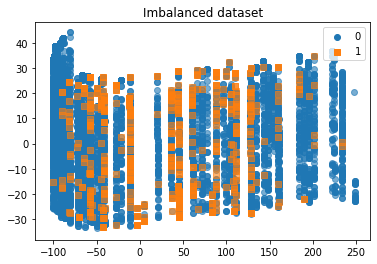

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_imbalanced = pca.fit_transform(X)

plot_2d_space(X_imbalanced, y, 'Imbalanced dataset')

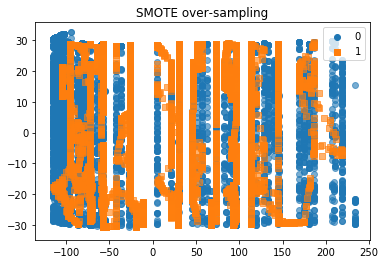

In [17]:
from imblearn.over_sampling import SMOTE

pca = PCA(n_components=2)
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_sample(X, y)

X_balanced = pca.fit_transform(X_sm)

plot_2d_space(X_balanced, y_sm, 'SMOTE over-sampling')

SMOTE will be used on the following models - logistic regression, SGD classifier, bagging classifier, AdaBoost classifier and gradient boosting classifier. We will explore the use of, 'class_weight' and 'scale_pos_weight' for random forest and XGBoost to manage our class imbalances.

## Logistic Regression

Logistic regression is one of the most commonly used methods for binary classification problems. We will apply logistic regression here to predict the probability of WNV presence.

In [18]:
%%time

# Create a pipeline
pipe_lr = make_pipeline(SMOTE(random_state=42),
                        StandardScaler(), # Scale features
                        LogisticRegression(random_state=42, tol=1000))

# Search over the following values of hyperparameters:
pipe_lr_params = {
    'logisticregression__penalty' : ['l2'], # L2 regularization will be better at managing multicollinearity
    'logisticregression__C' : [.001,.01,.1], # Regularization
    'logisticregression__max_iter' : [1000] 
}

# Instantiate GridSearchCV
gs_lr = GridSearchCV(pipe_lr,
                     param_grid=pipe_lr_params,
                     cv=5,
                     scoring='roc_auc')

# Fit model on training data
gs_lr.fit(X_train, y_train)

# Generate predictions on validation set
lr_pred = gs_lr.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_lr.best_params_)
print('Best CV ROC AUC score: ', gs_lr.best_score_)
print('Training ROC AUC score:', gs_lr.score(X_train, y_train))
print('Validation ROC AUC score:', gs_lr.score(X_val, y_val))
print('            ')

Best parameters:  {'logisticregression__C': 0.001, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2'}
Best CV ROC AUC score:  0.7963742070489237
Training ROC AUC score: 0.8026822181842723
Validation ROC AUC score: 0.7637230741146404
            
CPU times: user 1.94 s, sys: 87.7 ms, total: 2.03 s
Wall time: 536 ms


In [19]:
# Write a function that takes in the actual y value and model predictions, 
# and prints out the confusion matrix and classification report

def cmat(actual_y, predictions):
    # Create a confusion matrix
    cm = confusion_matrix(actual_y, predictions)
    cm_df = pd.DataFrame(cm, columns=['Predicted WNV Absent','Predicted WNV Present'], index=['Actual WNV Absent', 'Actual WNV Present'])
    print(cm_df)
    print('--------------------------------------------------------------')
    # Create a classification report
    print(classification_report(actual_y, predictions))

In [20]:
# Confusion matrix and classification report for Logistic Regression
cmat(actual_y=y_val, predictions=lr_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1382                    610
Actual WNV Present                    28                     82
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1992
           1       0.12      0.75      0.20       110

    accuracy                           0.70      2102
   macro avg       0.55      0.72      0.51      2102
weighted avg       0.94      0.70      0.78      2102



## SGD Classifier

SGD Classifier implements regularised linear models with Stochastic Gradient Descent. We will instantiate the SGDClassifier using loss='log' to implement the logistic regression and compare its performance to the previous model.

In [21]:
%%time

# Create a pipeline
pipe_sgd = make_pipeline(SMOTE(random_state=42), 
                         StandardScaler(), # Scale features
                         SGDClassifier(loss='log', max_iter=1000, random_state=42))

# Search over the following values of hyperparameters:
pipe_sgd_params = {
    'sgdclassifier__penalty': ['l2'], # L2 regularization will be better at managing multicollinearity
    'sgdclassifier__alpha': [.01,.1]
}

# Instantiate GridSearchCV
gs_sgd = GridSearchCV(pipe_sgd,
                      param_grid=pipe_sgd_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_sgd.fit(X_train, y_train)

# Generate predictions on validation set
sgd_pred = gs_sgd.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_sgd.best_params_)
print('Best CV ROC AUC score: ', gs_sgd.best_score_)
print('Training ROC AUC score:', gs_sgd.score(X_train, y_train))
print('Validation ROC AUC score:', gs_sgd.score(X_val, y_val))
print('            ')

Best parameters:  {'sgdclassifier__alpha': 0.01, 'sgdclassifier__penalty': 'l2'}
Best CV ROC AUC score:  0.8099843232908668
Training ROC AUC score: 0.817085853136516
Validation ROC AUC score: 0.7854508944870391
            
CPU times: user 2.09 s, sys: 67.4 ms, total: 2.16 s
Wall time: 544 ms


In [22]:
# Confusion matrix and classification report for SGD Classifier
cmat(actual_y=y_val, predictions=sgd_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1596                    396
Actual WNV Present                    46                     64
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1992
           1       0.14      0.58      0.22       110

    accuracy                           0.79      2102
   macro avg       0.56      0.69      0.55      2102
weighted avg       0.93      0.79      0.84      2102



## Bagging Classifier

As decision trees tend to overfit on the training data, we will use bagged decision trees instead. Bagging is an ensemble method that conducts random resampling with replacement to create multiple models and aggregates the predictions.

In [23]:
%%time

# Create a pipeline
pipe_bag = make_pipeline(SMOTE(random_state=42),
                         BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))

# Search over the following values of hyperparameters:
pipe_bag_params = {
    'baggingclassifier__n_estimators' : [100],
    'baggingclassifier__base_estimator__max_depth' : [2,3]
}

# Instantiate GridSearchCV
gs_bag = GridSearchCV(pipe_bag,
                      param_grid=pipe_bag_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_bag.fit(X_train, y_train)

# Generate predictions on validation set
bag_pred = gs_bag.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_bag.best_params_)
print('Best CV ROC AUC score: ', gs_bag.best_score_)
print('Training ROC AUC score:', gs_bag.score(X_train, y_train))
print('Validation ROC AUC score:', gs_bag.score(X_val, y_val))
print('            ')

Best parameters:  {'baggingclassifier__base_estimator__max_depth': 3, 'baggingclassifier__n_estimators': 100}
Best CV ROC AUC score:  0.7729608218249261
Training ROC AUC score: 0.7725832599354783
Validation ROC AUC score: 0.7528797006206644
            
CPU times: user 19.9 s, sys: 210 ms, total: 20.1 s
Wall time: 19.7 s


In [24]:
# Confusion matrix and classification report for Bagging Classifier
cmat(actual_y=y_val, predictions=bag_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1272                    720
Actual WNV Present                    18                     92
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1992
           1       0.11      0.84      0.20       110

    accuracy                           0.65      2102
   macro avg       0.55      0.74      0.49      2102
weighted avg       0.94      0.65      0.75      2102



## Random Forest Classifier

With bagged decision trees, we generate many trees on very similar data ie if a certain seasonality feature is a strong predictor of WNV, each bagged tree node will be simliar. These trees will thus be very strongly corelated with one another. Random forest will be useful in 'de-correlating' our trees. This is done by selecting a random subset of features at each node.

In [25]:
%%time

# Create a pipeline
# Handle imbalanced class by setting class_weight='balanced' in random forest
pipe_rf = make_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42))

# Search over the following values of hyperparameters:
pipe_rf_params = {
    'randomforestclassifier__n_estimators': [100,150],
    'randomforestclassifier__max_depth': [2,3]
}

# Instantiate GridSearchCV
gs_rf = GridSearchCV(pipe_rf,
                      param_grid=pipe_rf_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_rf.fit(X_train, y_train)

# Generate predictions on validation set
rf_pred = gs_rf.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_rf.best_params_)
print('Best CV ROC AUC score: ', gs_rf.best_score_)
print('Training ROC AUC score:', gs_rf.score(X_train, y_train))
print('Validation ROC AUC score:', gs_rf.score(X_val, y_val))
print('            ')

Best parameters:  {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 150}
Best CV ROC AUC score:  0.8269400945934233
Training ROC AUC score: 0.839099656774259
Validation ROC AUC score: 0.8055905439941584
            
CPU times: user 7.2 s, sys: 107 ms, total: 7.31 s
Wall time: 7.37 s


In [26]:
# Confusion matrix and classification report for Random Forest
cmat(actual_y=y_val, predictions=rf_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1302                    690
Actual WNV Present                    22                     88
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.65      0.79      1992
           1       0.11      0.80      0.20       110

    accuracy                           0.66      2102
   macro avg       0.55      0.73      0.49      2102
weighted avg       0.94      0.66      0.75      2102



## AdaBoost Classifer

AdaBoost is a boosting ensemble method that fits a sequence of weak learners on modified versions of the data. AdaBoost works by putting more weight on misclassifications and less on those already handled well. This allows it to convert a set of weak classifiers into a strong one.

In [27]:
%%time

# Create a pipeline
pipe_adaboost = make_pipeline(SMOTE(random_state=42),
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))

# Search over the following values of hyperparameters:
pipe_adaboost_params = {
    'adaboostclassifier__learning_rate': [0.9,1], #0.1
    'adaboostclassifier__n_estimators': [100], #150
    'adaboostclassifier__base_estimator__max_depth': [1] #2 
}

# Instantiate GridSearchCV
gs_adaboost = GridSearchCV(pipe_adaboost,
                          param_grid=pipe_adaboost_params,
                          cv=5,
                          scoring='roc_auc')

# Fit model on training data
gs_adaboost.fit(X_train, y_train)

# Generate predictions on validation set
adaboost_pred = gs_adaboost.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_adaboost.best_params_)
print('Best CV ROC AUC score: ', gs_adaboost.best_score_)
print('Training ROC AUC score:', gs_adaboost.score(X_train, y_train))
print('Validation ROC AUC score:', gs_adaboost.score(X_val, y_val))
print('            ')

Best parameters:  {'adaboostclassifier__base_estimator__max_depth': 1, 'adaboostclassifier__learning_rate': 0.9, 'adaboostclassifier__n_estimators': 100}
Best CV ROC AUC score:  0.8197682742055303
Training ROC AUC score: 0.8438063743225115
Validation ROC AUC score: 0.7855741146403797
            
CPU times: user 14.6 s, sys: 145 ms, total: 14.7 s
Wall time: 14.8 s


In [28]:
# Confusion matrix and classification report for AdaBoost
cmat(actual_y=y_val, predictions=adaboost_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1664                    328
Actual WNV Present                    54                     56
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1992
           1       0.15      0.51      0.23       110

    accuracy                           0.82      2102
   macro avg       0.56      0.67      0.56      2102
weighted avg       0.93      0.82      0.86      2102



## Gradient Boosting Classifier

While the AdaBoost model identifies the shortcomings by using high weight data points, gradient boosting performs the same by using gradients in the loss function.

In [29]:
%%time

# Create a pipeline
pipe_gb = make_pipeline(SMOTE(random_state=42),
                        GradientBoostingClassifier(random_state=42))

# Search over the following values of hyperparameters:
pipe_gb_params = {
    'gradientboostingclassifier__max_depth': [2], #3
    'gradientboostingclassifier__n_estimators': [100], #150
    'gradientboostingclassifier__learning_rate': [0.1] 
}

# Instantiate GridSearchCV
gs_gb = GridSearchCV(pipe_gb,
                     param_grid= pipe_gb_params,
                     cv=5,
                     scoring='roc_auc')

# Fit model on training data
gs_gb.fit(X_train, y_train)

# Generate predictions on validation set
gb_pred = gs_gb.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_gb.best_params_)
print('Best CV ROC AUC score: ', gs_gb.best_score_)
print('Training ROC AUC score:', gs_gb.score(X_train, y_train))
print('Validation ROC AUC score:', gs_gb.score(X_val, y_val))
print('            ')

Best parameters:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__n_estimators': 100}
Best CV ROC AUC score:  0.8225874638766142
Training ROC AUC score: 0.8496195413993803
Validation ROC AUC score: 0.7951122672508215
            
CPU times: user 11.7 s, sys: 118 ms, total: 11.8 s
Wall time: 11.9 s


In [30]:
# Confusion matrix and classification report for Gradient Boost
cmat(actual_y=y_val, predictions=gb_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1623                    369
Actual WNV Present                    43                     67
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.81      0.89      1992
           1       0.15      0.61      0.25       110

    accuracy                           0.80      2102
   macro avg       0.56      0.71      0.57      2102
weighted avg       0.93      0.80      0.85      2102



## XGBoost Classifier

XGBoost (eXtreme Gradient Boosting) is a decision-tree-based ensemble technique that uses a gradient boosting algorithm. Some key benefits of XGBoost includes the ability to regularize to reduce overfitting and its fast computational speed. The 'scale_pos_weight' hyperparameter helps to handle our imbalanced class. The recommended weight to use is the ratio of the number of negative class to the positive class.

In [31]:
# 7963 obs in negative class and 441 obs in positive class
y_train.value_counts()

0    7963
1     441
Name: wnvpresent, dtype: int64

In [32]:
%%time

# Create a pipeline
pipe_xgb = make_pipeline(XGBClassifier(random_state=42))

# Search over the following values of hyperparameters:
pipe_xgb_params = {
    'xgbclassifier__eval_metric' : ['auc'],
    'xgbclassifier__subsample' : [0.5], # Randomly sample 0.5 of the data to prevent overfitting
    'xgbclassifier__colsample_bytree' : [0.5], 
    'xgbclassifier__learning_rate' : [0.1], #0.5
    'xgbclassifier__max_depth' : [2, 3], #5
    'xgbclassifier__scale_pos_weight': [7963/441], # Ratio of negative class to positive class
    'xgbclassifier__n_estimators' : [100], #500
    'xgbclassifier__reg_alpha' : [100], # L1 regularization term on weight #0, 1, 50, 75
    'xgbclassifier__reg_lambda' : [100], # L2 regularization term on weights #0, 1, 2, 50,75
    'xgbclassifier__gamma' : [0.1], # Gamma specifies the minimum loss reduction required to make a split #.2
    'xgbclassifier__objective' : ['binary:logistic']
}

# Instantiate GridSearchCV
gs_xgb = GridSearchCV(pipe_xgb,
                      param_grid=pipe_xgb_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_xgb.fit(X_train, y_train)

# Generate predictions on validation set
xgb_pred = gs_xgb.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_xgb.best_params_)
print('Best CV ROC AUC score: ', gs_xgb.best_score_)
print('Training ROC AUC score:', gs_xgb.score(X_train, y_train))
print('Validation ROC AUC score:', gs_xgb.score(X_val, y_val))
print('            ')

Best parameters:  {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 100, 'xgbclassifier__reg_lambda': 100, 'xgbclassifier__scale_pos_weight': 18.05668934240363, 'xgbclassifier__subsample': 0.5}
Best CV ROC AUC score:  0.838559744153278
Training ROC AUC score: 0.8602682816188135
Validation ROC AUC score: 0.8261477729098211
            
CPU times: user 11.3 s, sys: 99.3 ms, total: 11.4 s
Wall time: 1.49 s


In [33]:
# Confusion matrix and classification report for XGBoost
cmat(actual_y=y_val, predictions=xgb_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1492                    500
Actual WNV Present                    24                     86
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1992
           1       0.15      0.78      0.25       110

    accuracy                           0.75      2102
   macro avg       0.57      0.77      0.55      2102
weighted avg       0.94      0.75      0.82      2102



The first iteration of XGBoost without tuning gave an ROC AUC score of 0.99 on the train set and 0.82 on the validation set, indicating a serious overfit. However, after some tuning and regularization, the model is now less overfitted, achieving an ROC AUC score of 0.86 on the train set and 0.83 on the validation set. As it outperforms all the other models on ROC AUC, we will use this as our final production model.

# Model Evaluation

## Summary Metrics

|                    | Logistic Regression | SGD  | Bagging | Random Forest | AdaBoost | Gradient Boost | XGBoost |
|:------------------:|---------------------|------|---------|---------------|----------|----------------|---------|
| Training ROC AUC   | 0.80                | 0.82 | 0.77    | 0.84          | 0.84     | 0.85           | 0.86    |
| Validation ROC AUC | 0.76                | 0.79 | 0.75    | 0.80          | 0.79     | 0.80           | **0.83**    |
| Recall             | 0.75                | 0.58 | 0.84    | 0.80          | 0.51     | 0.61           | 0.78    |

Out of all the 7 classification models built, XGBoost was selected as it achieved the highest ROC AUC score on the validation set. The model attained an ROC AUC of 0.83 on the validation set, outperforming the baseline score of 0.5. There is a 83% chance that the model will be able to distinguish between the positive and negative class - suggesting good class separation capacity.

Although the sole criteria in selecting our model was based on ROC AUC, it is also good to look at the recall rate. XGBoost performed decently well on this front, being able to correctly predict 78% of the actual WNV cases.

In [34]:
# Function to plot ROC curve with AUC
def plot_roc(model, X, actual_y, title):
    
    # Calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X)
    preds = probs[:,1]
    
    fpr, tpr, threshold = roc_curve(actual_y, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(7,5))
    plt.title(title +': ROC Curve with AUC = ' + '%0.2f' % roc_auc, fontsize=12, fontweight='bold')
    plt.plot(fpr, tpr, 'b', label='ROC Curve') # Plot the ROC curve
    plt.plot([0, 1], [0, 1],'r--', label='Baseline') # Plot baseline 
    plt.legend(loc = 'lower right')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');

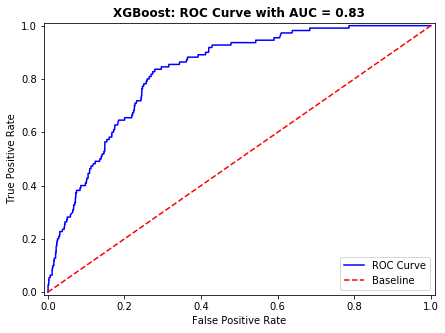

In [35]:
# Plot the ROC curve for XGBoost
plot_roc(model = gs_xgb, 
         X = X_val,
         actual_y = y_val,
         title = "XGBoost")

XGBoost classifier performed the best based on ROC AUC score, attaining 0.83 on the validation set.

In [36]:
# Find feature importance for XGBoost
feature_importance = gs_xgb.best_estimator_.named_steps["xgbclassifier"].feature_importances_

# Save feature importance to a dataframe
features_df = pd.DataFrame(index=X_train.columns, data = feature_importance, columns=['feature_importance'])

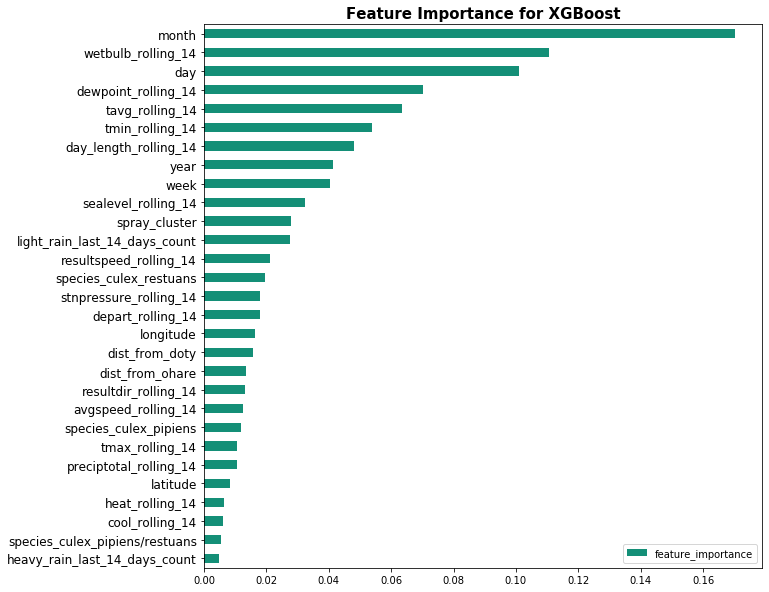

In [37]:
# Barplot for feature importance
features_df.sort_values(by='feature_importance', ascending=True).plot(kind='barh', figsize=(10,10), color='#148F77')
plt.title('Feature Importance for XGBoost', fontsize=15, weight='bold')
plt.yticks(fontsize=12);

Month is the most important predictor of WNV presence. Seasonality plays a very key role in mosquito breeding and the spread of WNV, with other features like week and day being within the top 5 most important features. This is possibly due the fact that these features capture a blend of weather conditions that are ideal for WNV. Rolling weather features over a 14-day period like wetbulb, dewpoint, minimum temperature and result speed were also key predictors. Location features like longitude was also useful in predicting possible hotspots, while spray cluster helped to identify the possible areas that were sprayed on to combat the WNV outbreak.

# Scoring on Kaggle

In [39]:
# Read in clean test set
test = pd.read_csv('../data/clean_test.csv')

In [40]:
X_test = test[[col for col in test.columns if col != 'id']]

In [41]:
# Generate predictions on test set
y_predict = gs_xgb.predict_proba(X_test)

In [42]:
# Create a dataframe for our predictions
result = pd.DataFrame(test['id'])

In [43]:
# Rename the column as per the sample file requirements
result.rename(columns={'id': 'Id'}, inplace=True)

In [44]:
# Probability of WNV presence 
result['WnvPresent'] = y_predict[:,1]

In [45]:
# Save predictions in result.csv and submit on Kaggle
result.to_csv('../data/result.csv', index=False)

Kaggle private and public score: 0.76

# Cost Benefit Analysis

The West Nile Virus was detected in the United States since 1999.

A research by Loren Barber,Jerome Schleier and Robert Peterson <sup>4</sup> assessed the financial cost of the 2005 West Nile Virus disease outbreak in Sacramento County, California, and evaluated that decrease in 15 WNV disease cases is needed to mitigate the cost of emergency aerial spray response. The West Nile Virus infection can be asymptomatic or symptomatic in humans, with a 4:1 proportion. 

Types of patients:
-  West Nile fever [WNF]: disease can be mild, causing flu-like side effects
- West Nile neuroinvasive disease [WNND]: severe, affecting the central nervous system symptom 

Types of costs:
- Inpatient Care: average charge of hospital patient discharge database from California’s Office of Statewide Health Planning and Development (OSHPD)
- Outpatient Care: using the 2002 outpatient costs determined by Zohrabian et al. and updated to 2005 using data from the Consumer Price Index (CPI) for the western United States, obtained from the US Department of Labor, Bureau of Labor Statistics
Productivity Loss. 
- Productivity loss: assumed 60 days. For caretakers, productivity loss was assumed to be 25 days. Using the mean annual earnings for full-time workers in 2005, the cost for a day of work missed by an average Sacramento adult citizen is calculated. The cost attributed to productivity loss is an estimate; true monetary value for pain and distress and the productivity loss associated with chronic WNND are uncertain.
- Miscellaneous: nursing home, transportation, home-health aides, and child care costs accrued during recovery. 3.6% of the WNND cases spent 96 days in nursing homes. The transportation cost to all WNND cases, and applied costs for home-help aides to 14.4% of the WNND cases.


**Out of 935 human WNV cases reported in California, 163 Cases were from Sacramento County in 2005**

*Cost of Medical Treatment*

|  -                                                        |  WNND : 46 cases (28.2%)                       |                                                                                                 |  WNF: 117 cases (71.8%)                        |                                                                                                 |
|-----------------------------------------------------------|-------------------------------|-------------------------------------------------------------------------------------------------|-------------------------------|-------------------------------------------------------------------------------------------------|
|  **Components**                                               |  **Estimated Cost of the cases**  |  **Estimated Cost under worst <br/> case scenario if full cost <br/> is applicable to all patients**  |  **Estimated Cost of the cases**  | **Estimated Cost under worst <br/> case scenario if full cost <br/> is applicable to all patients**  |
|  Inpatient Care                                           | `$`33143                         | `$`33143                                                                                           | -                             | -                                                                                               |
|  Outpatient Care                                          | `$`1758                          | `$`6317                                                                                            | `$`302                           | -                                                                                               |
|  Productivity Loss   | `$`10539                         | `$`10539                                                                                           | `$`868                           | `$`868                                                                                             |
|  Misc Expenses                                            | `$`1090                          | `$`11834                                                                                           | -                             | -                                                                                               |
|  **Total**                                                    | **`$`2140409**                       | **`$`2844338**                                                                                         | **`$`136839**                        | **`$`136839**                                                                                          |
|  **Per Pax Cost**                                             | **`$`46531**                         | **`$`61833**                                                                                           | **`$`1170**                          | **`$`1170**                                                                                            |

<br/>

*Cost of Spray*

| Components                                        | Spray Costs for 477km<sup>2</sup> |
|---------------------------------------------------|-------------|
| 1157 overtime hours                               | `$`41790       |
| Normal hours pay, insecticides, plane rental etc. | `$`660000      |
| **Total**                                             | **`$`701,790**     |


*Summary*

| Summary                             |         |
|-------------------------------------|---------|
| Total cost of medical treatment      | `$`1640780 |
| Total cost of productivity loss and misc expenses | `$`636490  |
| Total cost of spray                 | `$`701790  |
| **Total economic cost**             | **`$`2979060** |

<br/>

The actual number of disease cases prevented by the emergency spray is uncertain. But Carney et al. and Elnaiem et al. did provide evidence of the effectiveness of the 2005 spray by showing a reduction both in mosquito populations and WNV disease cases in humans. Zero cases were reported in spray area and 18 cases outside. This demonstrates the effectiveness of the spray and necessity of it. Even though these are pure estimation via sampling, the cost analysis suggest that only 15 WNND cases prevention is needed for the benefits of the spray response to exceed the expense of the virus for Sacramento County in 2005. 

Considering the land size and population<sup>7 </sup> in 2005, we assume similar spray area is needed to control Chicago mosquito population to reduce WNV and similar number of people were infected. Based on estimation, the spray data covers just under 100 km².

| Year 2005  | Sacramento County | Chicago            | Difference |
|------------|-------------------|--------------------|------------|
| Population | 1.36 Million      | 2.8 Million               | 1.44 Million       |
| Area       | 2,574 km²         | 606.1 km²          | 1968  km²      |
| Spray Area | 477 km²           | Calculated 112 km² |            |
| WNV cases  | 163 people        | Calculated 336 people |            |

| Year    | Cases of WnvPresent in traps in our data |
|---------|------------------------------------------|
| 2007    | 236                                      |
| 2009    | 19                                       |
| 2011    | 57                                       |
| 2013    | 239                                      |
| Average | 138                                      |

It is reasonable to that each cases of WnvPresent could have infected 3 people. Hence, let's consider **cost benefit analysis for 336 infected people and spray area of 112 km²**.

Assuming the proportion of people suffering WNND and WNF is similar to those in Sacramento County and costs are similar,

| Components                                          | Chicago WNV Cost Estimation for 2005 |
|-----------------------------------------------------|--------------------------------------|
| Per Pax cost of medical treatment                   | `$`10066                                |
| Per Pax cost of productivity loss and misc expenses | `$`3905                                 |
| Total per pax cost                                  | `$`13971                                |
| **Total cost for 336 people**                           | **`$`4694250**                              |
| **Cost of spray (112 km²)**                             | **`$`164781**                               |                                |
| **Total economic cost**                                 | **`$`4859031**                             |

Given the following parameters above, we make the **annual cost projections for the test data**.

| Year  | Total cost for 336 people | Cost of spray (112 km²) | Total economic cost | Consumer Price Index<sup>6</sup> |
|-------|---------------------------|-------------------------|---------------------|----------------------|
| 2005  | `$`4694250                   | `$`164781                  | `$`4859031             | -                    |
| 2008  | `$`5173063                   | `$`181589                  | `$`5354652             | 10.20%               |
| 2010  | `$`5240313                   | `$`183949                  | `$`5424262             | 1.30%                |
| 2012  | `$`5518050                   | `$`193698                  | `$`5711748             | 5.30%                |
| 2014  | `$`5689109                   | `$`199703                  | `$`5888812             | 3.10%                |

Although this estimation of the medical costs and the true number of cases prevented by the emergency spray are uncertain, it is likely that the true cost of the virus is higher than estimated. Pain, mental health costs, and ecological risks associated with the emergency spray is not included. There have been debate that the use of pesticides to slow the virus caused mass death of lobsters in 1999<sup>5 </sup>.

**Based on the above cost benefit analysis, spraying at areas with more than 12 WNV cases overweighs the cost of the spray, suggesting that spraying at those areas is the most cost effective solution. In addition, reduction in cost of 1 WNV case overweights the spraying of of 10km² area.**

# Conclusion and Recommendations

Out of all the classification models built, XGBoost was selected as it achieved the highest ROC AUC score on the validation set. The model attained an ROC AUC of 0.83 on the validation set, outperforming the baseline score of 0.5. As observed from the model's feature importance, it turns out that seasonality plays a very key role in mosquito breeding and the spread of WNV, with 'month' being the most important predictor. Besides other sesonality features like 'week' and 'day', 14-day rolling weather conditions like wetbulb, dewpoint and temperature are also key in predicting the presence of WNV in the City of Chicago. The model received a 0.76 ROC AUC score on Kaggle.<br/>

Based on the cost benefit analysis, spraying at areas with more than 12 WNV cases overweighs the cost of the spray, suggesting that spraying at those areas is the most cost effective solution. In addition, reduction in cost of 1 WNV case overweights the spraying of of 10km² area.<br/>

As the model performs relatively well on unseen data, the Disease and Treatment Agency will now be able deploy pesticide-spraying efforts to areas of high risk. An efficient allocation of resources will help help to clamp down on the WNV outbreak, reducing residents' exposure to the virus. 

Alternative method of solution may be vaccination. However, research analysis suggests that universal vaccination<sup>8</sup> against the West Nile Virus  would unlikely result in societal monetary savings unless disease incidence increases drastically. Hence, spraying is still the best method to reduce soceity impact at the moment until true ecological cost for the use of pesticide to kill the mosquitos are taken into account or cost of universal vaccination decreases.

We should also consider having more research to target specific breed of mosquito from the Culex family that carries the virus.




# Sources

<sup>1</sup> https://www.kaggle.com/c/predict-west-nile-virus/overview <br/>
<sup>2</sup> https://www.ncdc.noaa.gov/<br/>
<sup>3</sup> https://www.mosquito.org/page/lifecycle<br/>
<sup>4</sup> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/<br/>
<sup>5 </sup> https://www.nytimes.com/2002/08/11/nyregion/mosquito-control-weighing-costs-versus-benefits.html<br/>
<sup>6</sup> https://www.usinflationcalculator.com/<br/>
<sup>7 </sup> https://www.census.gov/glossary/#term_Populationestimates<br/>
<sup>8 </sup> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3291438/<br/>

# Acknowledgements 
This kaggle challenge provided by General Assembly is sponsored by the Robert Wood Johnson Foundation. Data is provided by the Chicago Department of Public Health.